# Data Cleaning

In [81]:
!pip install alerce

In [82]:
#install libraries

!pip install psycopg2-binary

### Imports

In [83]:
import psycopg2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime


from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis
from alerce.core import Alerce

In [84]:
client = Alerce()

In [85]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [86]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [87]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


In [88]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


In [89]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

(106896, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqpyv,154.226348,12.072717,59274.212454,1,0.710321
ZTF21aanqjqc,84.403597,10.469394,59274.147813,1,0.725208
ZTF21aanqpxc,157.088644,15.424231,59274.212454,1,0.728637
ZTF21aanqpzu,156.451785,14.969416,59274.212454,1,0.705238
ZTF21aanqpwg,156.660014,10.679691,59274.212454,1,0.700072


In [90]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
AND ssdistnr <= 5.0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

(106387, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
1,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263
2,ZTF18aaaxbuo,1547212622015015006,0.0,18.1,13289
3,ZTF18aabqfyb,1550307190015015012,0.0,19.8,349197
4,ZTF18aabwrag,1549239930415015008,0.0,20.0,175315


Text(0.5, 0, 'arcsec')

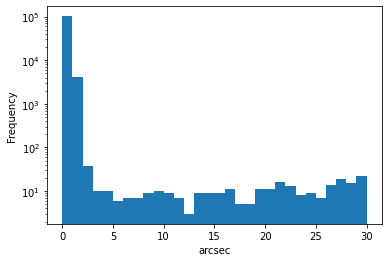

In [69]:
ax = ss.ssdistnr.plot.hist(bins=30, log=True)
ax.set_xlabel('arcsec')

In [78]:
ss_max_arsec = ss.ssdistnr < 5.0
ss_arcsec_filter = ss[ss_max_arsec]
ss_max_arsec

0         False
1          True
2          True
3          True
4          True
          ...  
106627     True
106628    False
106629    False
106630    False
106631     True
Name: ssdistnr, Length: 106632, dtype: bool

In [77]:
len(ss_arcsec_filter)/len(ss)

0.9976461099857453

In [22]:
from astropy.coordinates import SkyCoord
eq = SkyCoord(ast['meanra'].values, ast['meandec'].values, unit='deg', frame='icrs')
ecl = eq.barycentrictrueecliptic

In [23]:
ast["ecl_lat"] = ecl.lat.deg
ast["ecl_long"] = ecl.lon.deg

Text(0, 0.5, 'N')

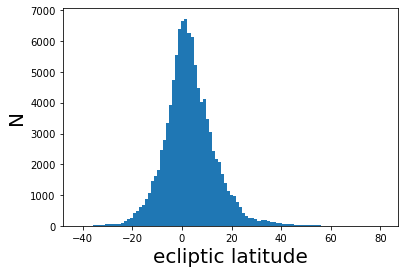

In [38]:
fig, ax = plt.subplots()
ax.hist(ast.ecl_lat, bins=100);
ax.set_xlabel("ecliptic latitude", fontsize=20)
ax.set_ylabel("N", fontsize=20)

In [39]:
minimo = np.percentile(ast.ecl_lat, 15)
maximo = np.percentile(ast.ecl_lat, 85)

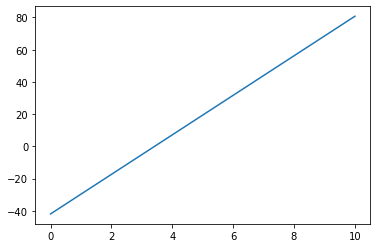

In [34]:
np.histogram(ast.ecl_lat, bins)[0]

In [ ]:
minimo = np.percentile(flux_x_tilt, 15)
maximo = np.percentile(flux_x_tilt, 85)